In [1]:
from pathlib import Path
outdir = Path("data/landing_in_space/")
outdir.mkdir(parents=True, exist_ok=True)
eval_data_fn = outdir / "eval_data_landing_in_space.csv"
context_name = "GRAVITY_Y"

In [25]:
from tqdm import tqdm
import pandas as pd
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
filters = {
    "config.experiment": "landing_in_space",
    "config.wandb.job_type": "eval"
}
runs = api.runs("tnt/carl-tmlr", filters=filters)

summary_list, config_list, name_list = [], [], []
for run in tqdm(runs):
    config = {k: v for k,v in run.config.items()
          if not k.startswith('_')}
    if "traincfg" not in list(config.keys()):
        print("traincfg not in config -- invalid")
        continue

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(config)

    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df.to_csv(eval_data_fn, index=False)

100%|██████████| 50/50 [00:00<00:00, 275.34it/s]


traincfg not in config -- invalid
traincfg not in config -- invalid
traincfg not in config -- invalid
traincfg not in config -- invalid
traincfg not in config -- invalid
traincfg not in config -- invalid
traincfg not in config -- invalid
traincfg not in config -- invalid
traincfg not in config -- invalid
traincfg not in config -- invalid


In [2]:
import sys
sys.path.append("../..")
import pandas as pd
from rich import print as printr
from ast import literal_eval
from pathlib import Path
from experiments.carlbench.context_logging import load_wandb_table_to_df
from experiments.policy_transfer.landing_in_space.definitions import gravities

gravities_keys = list(gravities.keys())


base_path = Path("/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/")
wandb_files_folder = "wandb/latest-run/files/"
runs_df = pd.read_csv(eval_data_fn)
rpc_df = []
for index, row in runs_df.iterrows():
    try:
        cfg = literal_eval(row["config"])
        # printr(cfg)
        traincfg = literal_eval(cfg["traincfg"])
        group_id = traincfg["wandb"]["group"]
        summary = literal_eval(row["summary"])
        wandb_id = cfg["wandb"]["id"]
        exp_folder = "/".join(wandb_id.split("_")[:-1])
        slurm_idx = cfg["slurm_id"].split("_")[-1]
        results_path = base_path / exp_folder / slurm_idx
        
        # Load eval contexts
        contexts_path = Path(results_path) / wandb_files_folder / summary["evalpost/contexts"]["path"]
        contexts = load_wandb_table_to_df(path=contexts_path)

        # Load return per context
        rpc_path = Path(results_path) / wandb_files_folder /  summary["return_per_context_table"]["path"]
        rpc = load_wandb_table_to_df(path=rpc_path)
        rpc["visibility"] = [group_id] * len(rpc)
        rpc["gravity"] = [contexts[context_name].iloc[int(i)] for i in rpc["context_id"]]

        gravs = gravities.values()
        is_planet_list = [g in gravs for g in rpc["gravity"]]
        planets = []
        for i, (is_planet, context_id) in enumerate(zip(is_planet_list, rpc["context_id"])):
            if is_planet:
                planet = gravities_keys[int(context_id)]
            else:
                planet = "space"
            planets.append(planet)
        rpc["planet"] = planets
        # rpc["planet"] = [gravities_keys[int(i)] for i in rpc["context_id"]]
        # rpc["gravity"] = rpc["gravity"].apply(lambda x: f"{x:.2f}")
        rpc_df.append(rpc)
    except Exception as e:
        printr(e)
        raise e
rpc_df = pd.concat(rpc_df)

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/brax/jumpy.py:70: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  flat_args, _ = jax.tree_flatten(a)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/brax/physics/base.py:191: UserWarning: dynamics_mode either not specified or not recognized, defaulting to "pbd".  If you wish to preserve legacy behavior used in previous versions of Brax, set dynamics_mode="legacy_spring".
  warnings.warn(
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/evaluation/../../carl/envs/mario/__init__.py:7: UserWarning: Could not load CARLMarioEnv which is probably not installed (No mod

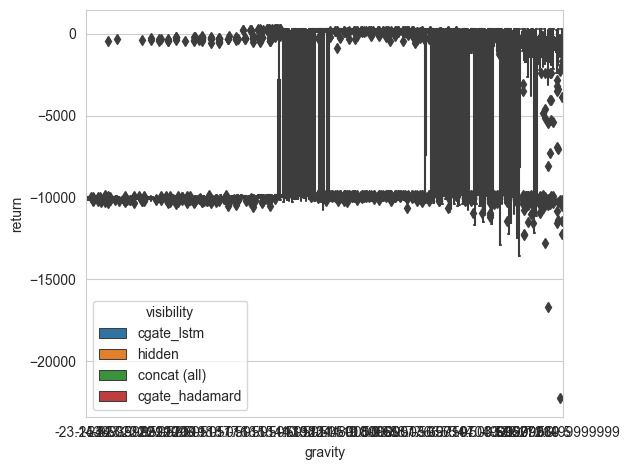

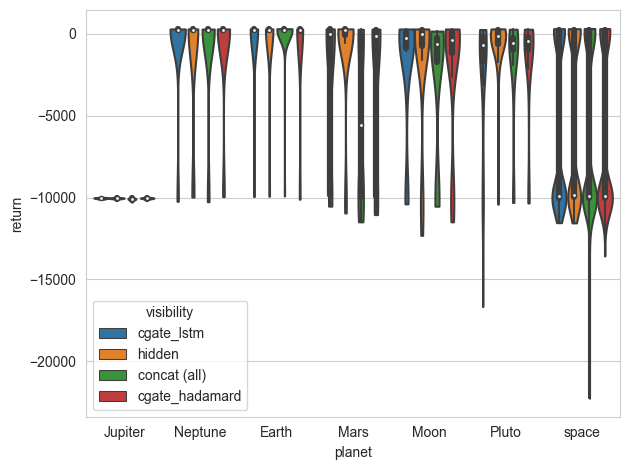

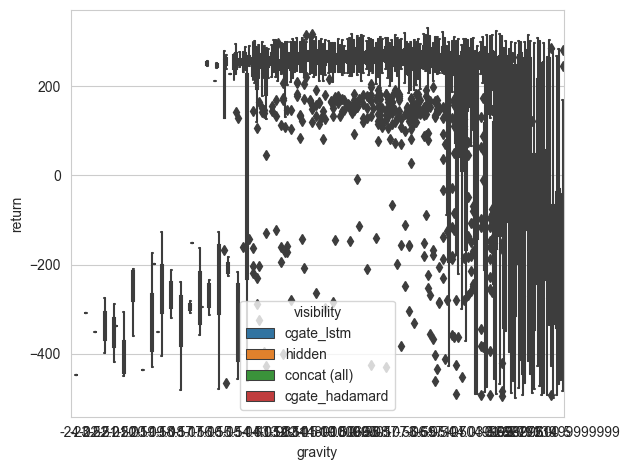

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

ymin = rpc_df["return"].min()
ymax = rpc_df["return"].max()
Y = rpc_df["return"].to_numpy()
Y = (Y - ymin) / (ymax - ymin) * (-1) + 1 
Y = np.log(Y + 1e-10)
# rpc_df["return"] = Y

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.boxplot(data=rpc_df, x="gravity", y="return", hue="visibility", ax=ax)
# ax.set_ylim(-300, 350)
fig.set_tight_layout(True)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.violinplot(data=rpc_df, x="planet", y="return", hue="visibility", ax=ax, cut=0)
fig.set_tight_layout(True)
plt.show()


filtered = rpc_df[rpc_df["return"] > -500]
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.boxplot(data=filtered, x="gravity", y="return", hue="visibility", ax=ax)
# ax.set_ylim(-300, 350)
fig.set_tight_layout(True)
plt.show()

# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax = sns.violinplot(data=rpc_df, x="visibility", y="return", ax=ax)
# fig.set_tight_layout(True)
# plt.show()

/tmp/ipykernel_14308/1613607134.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bboxh_inches" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(figfn, bboxh_inches="tight", dpi=300)


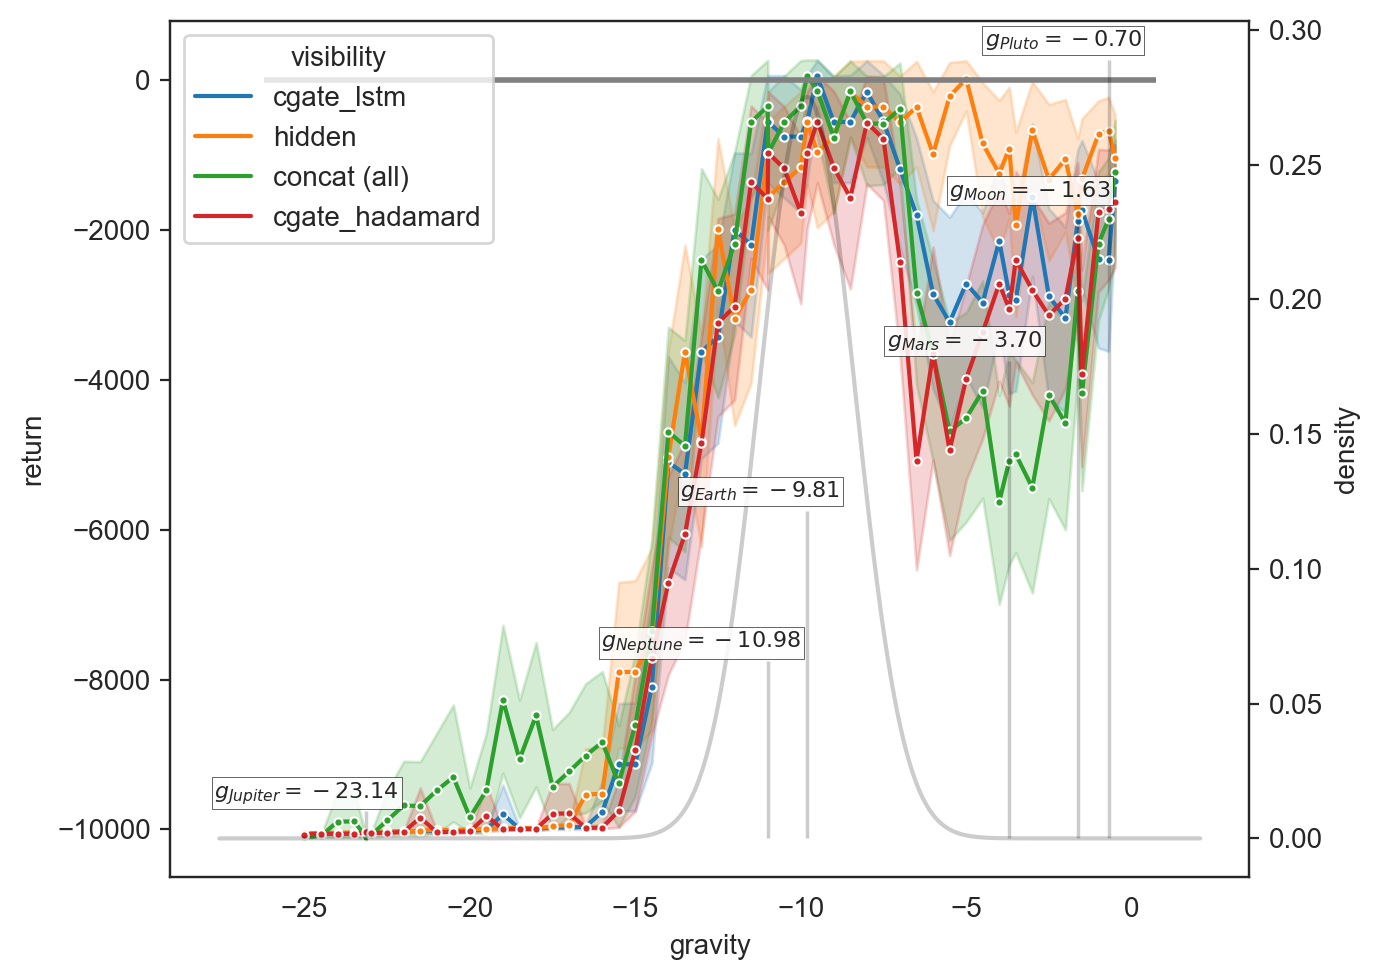

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from experiments.policy_transfer.plot_gravity_distribution import plot_gravities_vlines
sns.set_style("white")

mean = -9.81
std = 1.45
colordist = [0,0,0,0.2]

figfn = outdir / "landing_in_space_results.png"

rpc_df.reset_index(drop=True, inplace=True)
# rpc_df.drop(rpc_df[rpc_df["visibility"] == "cgate_lstm"].index, inplace=True)

plot_df = rpc_df.copy()

# plot_df = plot_df[plot_df["return"] > -5000]

# ymin = plot_df["return"].min()
# ymax = plot_df["return"].max()
# Y = plot_df["return"].to_numpy()
# Y = (Y - ymin) / (ymax - ymin) * (-1) + 1 
# Y = -np.log(Y + 1e-10)
# plot_df["return"] = Y

fig = plt.figure(figsize=(7,5), dpi=200)
ax = fig.add_subplot(111)
ax = sns.lineplot(data=plot_df, x="gravity", y="return", hue="visibility", ax=ax, ls="-", marker=".", errorbar="ci")
ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color="grey", lw=2)

# Plot distribution
ax = ax.twinx()
X = np.linspace(*ax.get_xlim(), 1000)
Y = norm.pdf(X, loc=mean, scale=std)
ax.plot(X, Y, color=colordist)
ax = plot_gravities_vlines(ax=ax, gravities=gravities, yvalue=ax.get_ylim()[1], mean=mean, std=std, fontsize=8, shortanno=True, colorline=colordist)
ax.set_ylabel("density")

fig.set_tight_layout(True)
fig.savefig(figfn, bboxh_inches="tight", dpi=300)
plt.show()

<AxesSubplot:xlabel='planet', ylabel='return'>

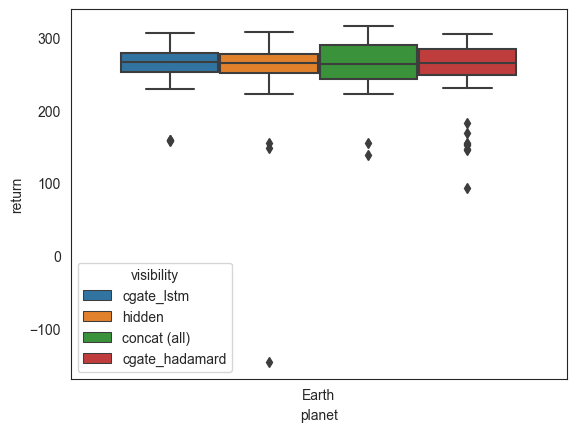

In [9]:
sns.boxplot(data=plot_df[(plot_df["planet"] == "Earth") & (plot_df["return"] > -5000)], x="planet", y="return", hue="visibility")

## Plot Histogram of Returns per Gravity

In [ ]:
plot_df = rpc_df.copy()
# plot_df = plot_df[plot_df["gravity"] > -5]
grid = sns.FacetGrid(data=plot_df, row="gravity", sharey=False)
grid.map_dataframe(sns.histplot, x="return", bins=30)
plt.show()

## Plot Number of Crashes

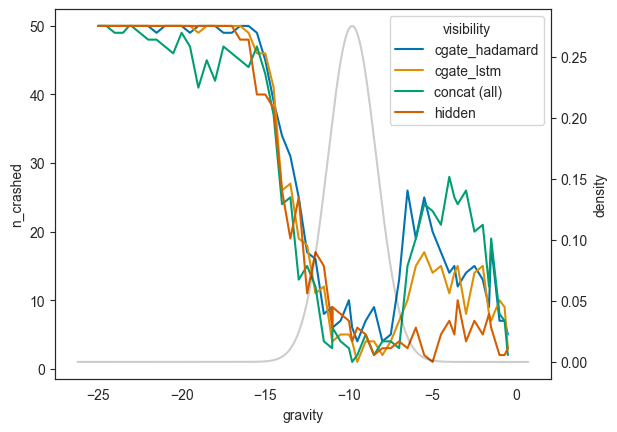

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig_fn = outdir / "landing_in_space_crashes.png"

plot_df = rpc_df.copy()

# plot_df = plot_df[plot_df["planet"] != "space"]

crashed_threshold = -5000
plot_df["crashed"] = plot_df["return"] < crashed_threshold

keys = ["gravity", "visibility", "planet"]
groups = plot_df.groupby(by=keys)
crash_df = []
for gid, gdf in groups:
    crashed = [int(c) for c in gdf["crashed"].to_list()]
    n_crashed = np.sum(crashed)
    crash_dict = {k: v for k, v in zip(keys, gid)}
    crash_dict["n_crashed"] = n_crashed
    crash_df.append(crash_dict)
crash_df = pd.DataFrame(crash_df)

fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.lineplot(data=crash_df, x="gravity", y="n_crashed", hue="visibility", palette="colorblind", marker="", ax=ax)

ax = ax.twinx()
X = np.linspace(*ax.get_xlim(), 1000)
Y = norm.pdf(X, loc=mean, scale=std)
ax.plot(X, Y, color=colordist)
ax.set_ylabel("density")
fig.savefig(fig_fn, dpi=300, bbox_inches="tight")


plt.show()

In [ ]:
ax.get_xticks()